In [1]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import time

In [2]:
def read_data(data_file, label_file, std):
    f = open(data_file, "rb")
    data2 = pickle.load(f)
    f.close()
    
    data_STDs = np.std(a=data2, axis=0)
    data = data2[:, data_STDs > std]
    
    data = np.divide(data, data.max())
    
    f = open(label_file, "rb")
    data_label = pickle.load(f)
    f.close()
    
    data_set = []
    
    for i in range(len(data)):
        label = np.array([0,0,0,0])
        label[int(data_label[i])] = 1
        label = label.reshape(4,1)
        data_set.append((data[i].reshape(102,1), label))
        
    return data_set

In [3]:
train_set = read_data("D:/My Projects/university/ebad/ANN_Project_Assets/Datasets/train_set_features.pkl", "D:/My Projects/university/ebad/ANN_Project_Assets/Datasets/train_set_labels.pkl", 52.3)
test_set = read_data("D:/My Projects/university/ebad/ANN_Project_Assets/Datasets/test_set_features.pkl", "D:/My Projects/university/ebad/ANN_Project_Assets/Datasets/test_set_labels.pkl", 48)

In [54]:
print(len(train_set))
test_valid = np.copy(list(train_set))
np.random.shuffle(test_valid)
examination_set = test_valid[0:200]

1962


In [5]:
def generate_wb():
    b0 = np.zeros((150, 1))
    b1 = np.zeros((60, 1))
    b2 = np.zeros((4, 1))
    
    w0 = np.random.randn(150, 102)
    w1 = np.random.randn(60, 150)
    w2 = np.random.randn(4, 60)
    
    w = [w0, w1, w2]
    b = [b0, b1, b2]
    
    return w, b

In [6]:
import math

def sigmoid(x):
    if x < 0:
        return 1 - 1 / (1 + math.exp(x))
    else:
        return 1 / (1 + math.exp(-x))

def prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

sigmoidVector = np.vectorize(sigmoid)
primeVector = np.vectorize(prime)

In [75]:
def feedforward(x, W, b):
    z = [0, 0, 0]
    a = [0, 0, 0]
    
    z[0] = ((W[0] @ x) + b[0])
    a[0] = sigmoidVector(z[0])
    
    z[1] = (W[1] @ sigmoidVector(z[0]) + b[1])
    a[1] = sigmoidVector(z[1])
    
    z[2] = (W[2] @ sigmoidVector(z[1]) + b[2])
    a[2] = sigmoidVector(z[2])
    
    return a, z

In [8]:
def getcost(a, y):
    cost = 0
    for i in range(4):
        cost += (a[i] - y[i]) ** 2
    return cost

In [9]:
def SGD(input_set, W, b):
    start = time.process_time()
    batch_size = 10
    learning_rate = 1
    number_of_epochs = 5
    data_set = np.copy(input_set)
    costs = []
    
    for i in range(number_of_epochs):
        np.random.shuffle(data_set)
        batches = []
        cost = 0
        
        for l in range(0, len(data_set), batch_size):
            batches.append(data_set[l: l + batch_size])
            
        for batch in batches:
            
            for image in batch:
                W2_grad = np.zeros((4, 60))
                b2_grad = np.zeros((4, 1))
                a2_grad = np.zeros((60, 1))
                W1_grad = np.zeros((60, 150))
                b1_grad = np.zeros((60, 1))
                a1_grad = np.zeros((150, 1))
                W0_grad = np.zeros((150, 102))
                b0_grad = np.zeros((150, 1))
                W_grad = [W0_grad, W1_grad, W2_grad]
                b_grad = [b0_grad, b1_grad, b2_grad]
                
                x = image[0]
                y = image[1]
                a, z = feedforward(x, W, b)
                cost += getcost(a[2],y)
                
                #last layer
                for j in range(4):
                    b_grad[2][j, 0] += 2 * (a[2][j, 0] - y[j,0]) * primeVector(z[2][j, 0])
                    for k in range(60):
                        W_grad[2][j][k] += 2 * (a[2][j, 0] - y[j,0]) *  primeVector(z[2][j, 0]) * a [1][k, 0]

                for k in range(60):
                    for j in range(4):
                        a2_grad[k, 0] += primeVector(z[2][j, 0]) * W[2][j][k] * 2 * (a[2][j, 0] - y[j,0])

                #3rd layer
                for j in range(60):
                    b_grad[1][j, 0] += a2_grad[j, 0] * primeVector(z[1][j, 0]) #ihi
                    for k in range(150):
                        W_grad[1][j][k] += a2_grad[j,0] * primeVector(z[1][j, 0]) * a[0][k, 0] #problem

                for k in range(150):
                    for j in range(60):
                        a1_grad[k, 0] += a2_grad[j, 0] * primeVector(z[1][j, 0]) * W[1][j, k]

                #second layer
                for j in range(150):
                    b_grad[0][j, 0] += a1_grad[j, 0] * primeVector(z[0][j, 0])
                    for k in range(102): 
                        W_grad[0][j][k] += a1_grad[j, 0] * primeVector(z[0][j, 0]) * x[k]

            #updating
            for j in range(4):
                b[2][j, 0] = b[2][j, 0] - learning_rate * (b_grad[2][j, 0] / batch_size)
                for k in range(60):
                    W[2][j, k] = W[2][j, k] - learning_rate * (W_grad[2][j,k] / batch_size)

            for j in range(60):
                b[1][j, 0] = b[1][j, 0] - learning_rate * (b_grad[1][j, 0] / batch_size)
                for k in range(150):
                    W[1][j, k] = W[1][j, k] - learning_rate * (W_grad[1][j, k] / batch_size)

            for j in range(150):
                b[0][j, 0] = b[0][j, 0] - learning_rate * (b_grad[0][j, 0] / batch_size)
                for k in range(102):
                    W[0][j, k] = W[0][j, k] - learning_rate * (W_grad[0][j, k] / batch_size)
        costs.append(cost / len(data_set))
    
    print("Time:")
    print(time.process_time() - start)
    return W, b, costs

In [10]:
def getFinal(x, W, b):
    a, _ = feedforward(x, W, b)
    return np.argmax(a[2])

def measure_accuracy(X_set, W, b):
    result = [getFinal(image[0], W, b) for image in X_set]
    return sum(1 for i, image in enumerate(X_set) if np.argmax(image[1]) == result[i]) / len(X_set) * 100


In [11]:
W, b = generate_wb()

In [86]:
print(measure_accuracy(examination_set, W, b))

21.5


In [87]:
W_new, b_new, costs = SGD(list(examination_set), W, b)

Time:
1707.296875


58.5


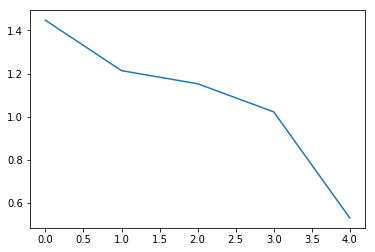

In [88]:
print(measure_accuracy(examination_set, W_new, b_new))
plt.plot(costs)

In [78]:
def V_SGD(input_set, batch_size, learning_rate, number_of_epochs):
    W, b = generate_wb()
    costs = []
    train_set = input_set.copy()

    for i in range(number_of_epochs):
        cost = 0
        np.random.shuffle(train_set)
        batches = []

        for l in range(0,len(train_set), batch_size):
            batches.append(train_set[l: l + batch_size])

        for batch in batches:
    

            for image in batch:
                W2_grad = np.zeros((4, 60))
                b2_grad = np.zeros((4, 1))
                a2_grad = np.zeros((60, 1))
                W1_grad = np.zeros((60, 150))
                b1_grad = np.zeros((60, 1))
                a1_grad = np.zeros((150, 1))
                W0_grad = np.zeros((150, 102))
                b0_grad = np.zeros((150, 1))
                W_grad = [W0_grad, W1_grad, W2_grad]
                b_grad = [b0_grad, b1_grad, b2_grad]
                x = image[0]
                y = image[1]
                a, z = feedforward(x, W, b)
                cost += getcost(a[2],y)
                b_grad[2] += 2 * primeVector(z[2]) * (a[2] - y)
                W_grad[2] += (2 * primeVector(z[2])* (a[2] - y)) @ np.transpose(a[1])
                a2_grad += np.transpose(W[2]) @ (2 * primeVector(z[2]) * (a[2] - y))
                b_grad[1] += a2_grad * primeVector(z[1])
                W_grad[1] += a2_grad * primeVector(z[1]) @ np.transpose(a[0]) 
                a1_grad += np.transpose(W[1]) @ (a2_grad * primeVector(z[1]))
                b_grad[0] += a1_grad * primeVector(z[0])
                x = x.reshape(102,1)
                W_grad[0] += (a1_grad * primeVector(z[0])) @ np.transpose(x)
            b[2] = b[2] - learning_rate * (b_grad[2] / batch_size)
            b[1] = b[1] - learning_rate * (b_grad[1] / batch_size)
            b[0] = b[0] - learning_rate * (b_grad[0] / batch_size)
            W[2] = W[2] - learning_rate * (W_grad[2] / batch_size)
            W[1] = W[1] - learning_rate * (W_grad[1] / batch_size)
            W[0] = W[0] - learning_rate * (W_grad[0] / batch_size)
        costs.append(cost / len(train_set))
    return W, b, costs

In [79]:
accuracy = 0
ave_costs = []
for i in range(10):
    W_2, b_2, costs = V_SGD(list(examination_set), batch_size=10, learning_rate=1, number_of_epochs=20)
    
    if i == 0:
        ave_costs = costs
    else:
        ave_costs = [x + y for (x, y) in zip(ave_costs, costs)]
        
    acc = measure_accuracy(examination_set, W_2, b_2)
    accuracy += acc
    

result-train-200
62.8


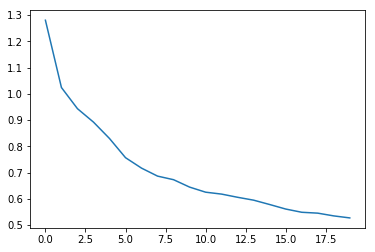

In [80]:
print("result-train-200")  
print(accuracy/10)
plt.plot([x / 10 for x in ave_costs])

In [81]:
accuracy = 0
ave_costs = []
for i in range(10):
    W_2, b_2, costs = V_SGD(list(train_set), batch_size=10, learning_rate=1, number_of_epochs=10)
    
    if i == 0:
        ave_costs = costs
    else:
        ave_costs = [x + y for (x, y) in zip(ave_costs, costs)]
        
    acc = measure_accuracy(examination_set, W_2, b_2)
    accuracy += acc

result-train
91.95


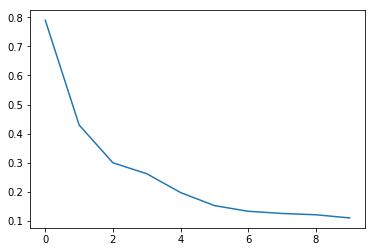

In [82]:
print("result-train")  
print(accuracy/10)
plt.plot([x / 10 for x in ave_costs])

In [83]:
accuracy = 0
ave_costs = []
for i in range(10):
    W_2, b_2, costs = V_SGD(list(test_set), batch_size=10, learning_rate=1, number_of_epochs=10)
    
    if i == 0:
        ave_costs = costs
    else:
        ave_costs = [x + y for (x, y) in zip(ave_costs, costs)]
        
    acc = measure_accuracy(examination_set, W_2, b_2)
    accuracy += acc

result-test
91.0


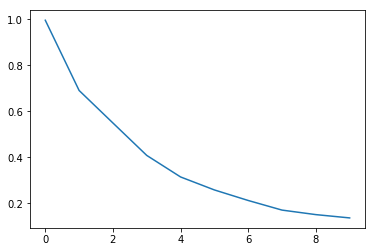

In [85]:
print("result-test")  
print(accuracy/10)
plt.plot([x / 10 for x in ave_costs])

In [89]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_prime(x):
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

softmaxVector = np.vectorize(softmax)
softmaxPrimeVector = np.vectorize(softmax_prime)

In [108]:
def feedforward_softmax(x, W, b):
    z = [0, 0, 0]
    a = [0, 0, 0]
    
    z[0] = ((W[0] @ x) + b[0])
    a[0] = sigmoidVector(z[0])
    
    z[1] = (W[1] @ sigmoidVector(z[0]) + b[1])
    a[1] = sigmoidVector(z[1])
    
    z[2] = (W[2] @ sigmoidVector(z[1]) + b[2])
    a[2] = softmaxVector(z[2])

    
    return a, z

def calc_softmax(x, W, b):
    a, _ = feedforward_softmax(x, W, b)
    return np.argmax(a)

def measure_softmax_accuracy(X_set, W, b):
    result = [calc_softmax(image[0], W, b) for image in X_set]
    return sum(1 for i, image in enumerate(X_set) if np.argmax(image[1]) == result[i]) / len(X_set) * 100


def V_SGD_softmax(input_set, batch_size, learning_rate, number_of_epochs):
    W, b = generate_wb()
    costs = []
    train_set = input_set.copy()

    for i in range(number_of_epochs):
        cost = 0
        np.random.shuffle(train_set)
        batches = []

        for l in range(0,len(train_set), batch_size):
            batches.append(train_set[l: l + batch_size])

        for batch in batches:
            

            for image in batch:
                W2_grad = np.zeros((4, 60))
                b2_grad = np.zeros((4, 1))
                a2_grad = np.zeros((60, 1))
                W1_grad = np.zeros((60, 150))
                b1_grad = np.zeros((60, 1))
                a1_grad = np.zeros((150, 1))
                W0_grad = np.zeros((150, 102))
                b0_grad = np.zeros((150, 1))
                W_grad = [W0_grad, W1_grad, W2_grad]
                b_grad = [b0_grad, b1_grad, b2_grad]
                x = image[0]
                y = image[1]
                a, z = feedforward_softmax(x, W, b)
                
                cost += getcost(a[2],y)
                b_grad[2] += 2 * (softmax_prime(z[2]) * (a[2] - y))[0]
                W_grad[2] += (2 * softmax_prime(z[2])* (a[2] - y)) @ np.transpose(a[1])
                a2_grad += np.transpose(W[2]) @ (2 * softmax_prime(z[2]) * (a[2] - y))
                b_grad[1] += a2_grad * primeVector(z[1])
                W_grad[1] += a2_grad * primeVector(z[1]) @ np.transpose(a[0]) 
                a1_grad += np.transpose(W[1]) @ (a2_grad * primeVector(z[1]))
                b_grad[0] += a1_grad * primeVector(z[0])
                x = x.reshape(102,1)
                W_grad[0] += (a1_grad * primeVector(z[0])) @ np.transpose(x)
            b[2] = b[2] - learning_rate * (b_grad[2] / batch_size)
            b[1] = b[1] - learning_rate * (b_grad[1] / batch_size)
            b[0] = b[0] - learning_rate * (b_grad[0] / batch_size)
            W[2] = W[2] - learning_rate * (W_grad[2] / batch_size)
            W[1] = W[1] - learning_rate * (W_grad[1] / batch_size)
            W[0] = W[0] - learning_rate * (W_grad[0] / batch_size)
        costs.append(cost / len(train_set))
    return W, b, costs

In [109]:
accuracy = 0
ave_costs = []
for i in range(10):
    W_2, b_2, costs = V_SGD_softmax(list(examination_set), batch_size=10, learning_rate=1, number_of_epochs=10)
    
    if i == 0:
        ave_costs = costs
    else:
        ave_costs = [x + y for (x, y) in zip(ave_costs, costs)]
        
    acc = measure_softmax_accuracy(examination_set, W_2, b_2)
    accuracy += acc
    

ValueError: non-broadcastable output operand with shape (4,1) doesn't match the broadcast shape (4,4)

In [ ]:
print("result-train-200-softmax")  
print(accuracy/10)
plt.plot([x / 10 for x in ave_costs])